In [3]:
%pip install -U torch scikit-learn pandas tensorflow keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# setting up seed and device
from typing import Any
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

First, we'll read the relevant data.

In [5]:
# read the data, fill missing data with 0
import pandas as pd
train_df = pd.read_csv("./data/train.csv", encoding="utf-8").fillna(0)
test_df = pd.read_csv("./data/test.csv", encoding="utf-8").fillna(0)



I just need to make sense of this transformation. Apparently, it removes the last column...

In [6]:
import numpy as np
# remove the last column
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

print(f"A = {A}")
print(f"A[:, :-1] = {A[:, :-1]}")

A = [[1 2 3]
 [4 5 6]
 [7 8 9]]
A[:, :-1] = [[1 2]
 [4 5]
 [7 8]]


Then, we'll process it.

In [7]:
# basic data preview
train_df.head(5)

,5 Minutes,Lane 1 Flow (Veh/5 Minutes),# Lane Points,% Observed
0,04/01/2016 0:00,12,1,100
1,04/01/2016 0:05,13,1,100
2,04/01/2016 0:10,11,1,100
3,04/01/2016 0:15,13,1,100
4,04/01/2016 0:20,10,1,100


In [8]:
# hyperparameter

lag = 12

In [9]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

train_col: str = "Lane 1 Flow (Veh/5 Minutes)"

# fit scaler on training column

# FIX: Fit scaler on TRAINING data, not test data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(
    train_df[train_col].values.reshape(-1, 1)  # ✅ Use train_df
)

train_flow = scaler.transform(train_df[train_col].values.reshape(-1, 1)).reshape(-1, 1)
test_flow = scaler.transform(test_df[train_col].values.reshape(-1, 1)).reshape(-1, 1)

train = []
test = []

for i in range(lag, len(train_flow)):
    train.append(train_flow[i - lag : i + 1])
for i in range(lag, len(test_flow)):
    test.append(test_flow[i - lag : i + 1])
    
train_array = np.array(train, )
test_array = np.array(test,)
np.random.shuffle(train_array)

# train: all values other than last column
# test: last column
X_train = train_array[:, :-1]
y_train = train_array[:, -1]
X_test = test_array[:, :-1]
y_test = test_array[:, -1]





In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (7764, 12, 1)
Shape of X_test: (4308, 12, 1)
Shape of y_train: (7764, 1)
Shape of y_test: (4308, 1)


We then process the dataset to a suitable form of training.

In [11]:
from torch.utils.data import TensorDataset, DataLoader

batch = 256
epochs = 10 #test
lr = 0.001
val = 0.05 # validation ratio

X_train_tensor = torch.from_numpy(X_train).to(torch.float32) # Add feature dimension
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
X_test_tensor = torch.from_numpy(X_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)

val_size = int(len(X_train_tensor) * 0.05)
X_val = X_train_tensor[-val_size:]
y_val = y_train_tensor[-val_size:]
X_train_split = X_train_tensor[:-val_size]
y_train_split = y_train_tensor[:-val_size]

train_dataset = TensorDataset(X_train_split, y_train_split)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

We implement the custom loss used in the original training: MAPE

In [12]:
import torch
from torch import nn, Tensor, optim
from torch.nn import functional as F

class MAPELoss(nn.Module):
    def __init__(self, eps: float = 1e-7):
        super().__init__()
        self.eps = eps  # avoid division by zero
        
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        # Formula: mean( |(target - input) / clip(|target|, eps, inf)| ) * 100
        denom = torch.clamp(torch.abs(target), min=self.eps)
        loss = torch.mean(torch.abs((target - input) / denom)) * 100
        return loss

mse = nn.MSELoss()
mape = MAPELoss()

In [13]:

class LSTM(nn.Module):
    def __init__(self, units: list[int], *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=units[1], batch_first=True, num_layers=1)
        self.lstm2 = nn.LSTM(input_size=units[1], hidden_size=units[2], batch_first=True, num_layers=1)
        self.dropout = nn.Dropout(0.2)
        # self.linear = nn.Linear(in_features = units[2], out_features=units[3])
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(units[2], units[3]),
            nn.Sigmoid()
        )
        
        
    def forward(self, x: Tensor) -> Tensor:
        # lstm layer 1
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # keeps every sequence in the batch (:) but selects only the last 
        # time-step (-1) from the sequence dimension, leaving a tensor of shape 
        # (batch_size, hidden_size) for the final linear layer.
        x = x[:, -1, :]
        x = self.dropout(x)
        return self.head(x)

lstm = LSTM([12, 64, 64, 1])
lstm.to(device)


LSTM(
  (lstm1): LSTM(1, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (head): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

Optimize the LSTM model


Note that Criterion here is MSE.

In [19]:

optimizer = optim.RMSprop(
    lstm.parameters(), lr=1e-3, alpha=0.9, eps=1e-6
)

mse_metric = nn.MSELoss()
mape_metric = MAPELoss()

history = {'mse': [], 'val_mse': [], 'mape': [], 'val_mape': []}

epochs = 600

for epoch in range(epochs):
    lstm.train()
    train_mse: float = 0
    train_mape: float = 0
    
    # evaluate error over batch
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = lstm(batch_X)
        mse = mse_metric(outputs, batch_y)
        mape = mape_metric(outputs, batch_y)
        
        mse.backward()
        optimizer.step()
        
        train_mse += mse.item()
        train_mape += mape.item()
        
    train_mse /= len(train_loader)
    train_mape /= len(train_loader)
    history["mse"].append(train_mse)
    history["mape"].append(train_mape)
    
    # validation
    lstm.eval()
    with torch.no_grad():
        X_val_device = X_val.to(device)
        y_val_device = y_val.to(device)
        val_outputs = lstm(X_val_device)
        val_mse = mse_metric(val_outputs, y_val_device).item()
        val_mape = mape_metric(val_outputs, y_val_device).item()
        history["val_mse"].append(val_mse)
        history["val_mape"].append(val_mape)
        
        
    # compute MAPE on denormalized values
    # with torch.no_grad():
    
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}, '
              f'MAPE: {train_mape:.2f}%, Val MAPE: {val_mape:.2f}%')
        

Epoch [10/600], MSE: 0.002275, Val MSE: 0.002327, MAPE: 26492.83%, Val MAPE: 14.38%
Epoch [20/600], MSE: 0.002247, Val MSE: 0.002369, MAPE: 24395.09%, Val MAPE: 16.37%
Epoch [30/600], MSE: 0.002256, Val MSE: 0.002445, MAPE: 21939.94%, Val MAPE: 15.27%
Epoch [40/600], MSE: 0.002266, Val MSE: 0.002240, MAPE: 22172.58%, Val MAPE: 14.87%
Epoch [50/600], MSE: 0.002239, Val MSE: 0.002247, MAPE: 22073.81%, Val MAPE: 15.36%
Epoch [60/600], MSE: 0.002258, Val MSE: 0.002301, MAPE: 18285.16%, Val MAPE: 16.87%
Epoch [70/600], MSE: 0.002244, Val MSE: 0.002278, MAPE: 20078.58%, Val MAPE: 14.34%
Epoch [80/600], MSE: 0.002245, Val MSE: 0.002268, MAPE: 19181.90%, Val MAPE: 14.89%
Epoch [90/600], MSE: 0.002204, Val MSE: 0.002353, MAPE: 23333.03%, Val MAPE: 14.63%
Epoch [100/600], MSE: 0.002212, Val MSE: 0.002401, MAPE: 16953.81%, Val MAPE: 14.52%
Epoch [110/600], MSE: 0.002241, Val MSE: 0.002366, MAPE: 16955.37%, Val MAPE: 17.20%
Epoch [120/600], MSE: 0.002240, Val MSE: 0.002297, MAPE: 19656.27%, Val MA

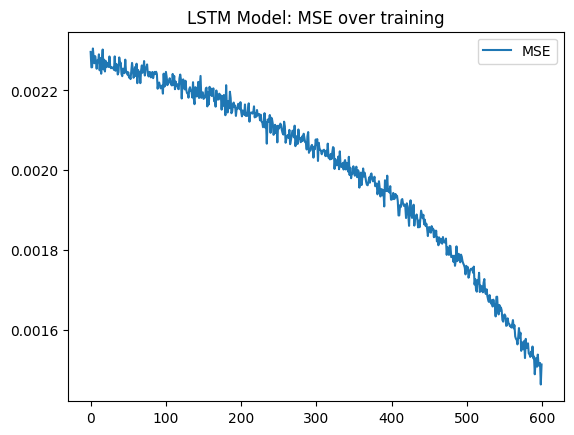

In [23]:
from matplotlib import pyplot as plt 

# plot history

# print(history)

X_axis = np.arange(epochs)

plt.title("LSTM Model: MSE over training")

plt.plot(X_axis, history["mse"], label = "MSE")
# plt.plot(X_axis, history["mape"], label = "MAPE")

plt.legend()
plt.show()


In [33]:
class GRU(nn.Module):
    def __init__(self, units: list[int], *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gru1 = nn.GRU(input_size=1, hidden_size=units[1], batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(input_size=units[1], hidden_size=units[2], batch_first=True, num_layers=1)
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(units[2], units[3]),
            nn.Sigmoid()
        )
        # print(len(self.lstm1))
        # print(len(self.lstm2))
        # print(len(self.dropout))
        
    def forward(self, x: Tensor) -> Tensor:
        # lstm layer 1
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        
        # keeps every sequence in the batch (:) but selects only the last 
        # time-step (-1) from the sequence dimension, leaving a tensor of shape 
        # (batch_size, hidden_size) for the final linear layer.
        x = x[:, -1, :]
        return self.head(x)
    
gru = GRU([12, 64, 64, 1])
gru.to(device)



GRU(
  (gru1): GRU(1, 64, batch_first=True)
  (gru2): GRU(64, 64, batch_first=True)
  (head): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [34]:

optimizer = optim.RMSprop(
    gru.parameters(), lr=1e-3, alpha=0.9, eps=1e-6
)

mse_metric = nn.MSELoss()
mape_metric = MAPELoss()

history = {'mse': [], 'val_mse': [], 'mape': [], 'val_mape': []}

epochs = 600

for epoch in range(epochs):
    gru.train()
    train_mse: float = 0
    train_mape: float = 0
    
    # evaluate error over batch
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = gru(batch_X)
        mse = mse_metric(outputs, batch_y)
        mape = mape_metric(outputs, batch_y)
        
        mse.backward()
        optimizer.step()
        
        train_mse += mse.item()
        train_mape += mape.item()
        
    train_mse /= len(train_loader)
    train_mape /= len(train_loader)
    history["mse"].append(train_mse)
    history["mape"].append(train_mape)
    
    # validation
    gru.eval()
    with torch.no_grad():
        X_val_device = X_val.to(device)
        y_val_device = y_val.to(device)
        val_outputs = gru(X_val_device)
        val_mse = mse_metric(val_outputs, y_val_device).item()
        val_mape = mape_metric(val_outputs, y_val_device).item()
        history["val_mse"].append(val_mse)
        history["val_mape"].append(val_mape)
        
        
    # compute MAPE on denormalized values
    # with torch.no_grad():
    
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}, '
              f'MAPE: {train_mape:.2f}%, Val MAPE: {val_mape:.2f}%')
        

Epoch [10/600], MSE: 0.003464, Val MSE: 0.004182, MAPE: 31433.15%, Val MAPE: 32.36%
Epoch [20/600], MSE: 0.003151, Val MSE: 0.003049, MAPE: 32479.77%, Val MAPE: 18.28%
Epoch [30/600], MSE: 0.002959, Val MSE: 0.003045, MAPE: 29202.56%, Val MAPE: 22.33%
Epoch [40/600], MSE: 0.002843, Val MSE: 0.002717, MAPE: 24583.37%, Val MAPE: 24.83%
Epoch [50/600], MSE: 0.002788, Val MSE: 0.002505, MAPE: 22799.16%, Val MAPE: 16.97%
Epoch [60/600], MSE: 0.002709, Val MSE: 0.002678, MAPE: 24310.39%, Val MAPE: 17.95%
Epoch [70/600], MSE: 0.002749, Val MSE: 0.002558, MAPE: 24953.27%, Val MAPE: 16.54%
Epoch [80/600], MSE: 0.002726, Val MSE: 0.002526, MAPE: 25892.99%, Val MAPE: 15.38%
Epoch [90/600], MSE: 0.002693, Val MSE: 0.002739, MAPE: 23518.56%, Val MAPE: 16.96%
Epoch [100/600], MSE: 0.002645, Val MSE: 0.002551, MAPE: 25861.85%, Val MAPE: 17.38%
Epoch [110/600], MSE: 0.002636, Val MSE: 0.002526, MAPE: 22850.16%, Val MAPE: 21.01%
Epoch [120/600], MSE: 0.002630, Val MSE: 0.002464, MAPE: 31857.08%, Val MA

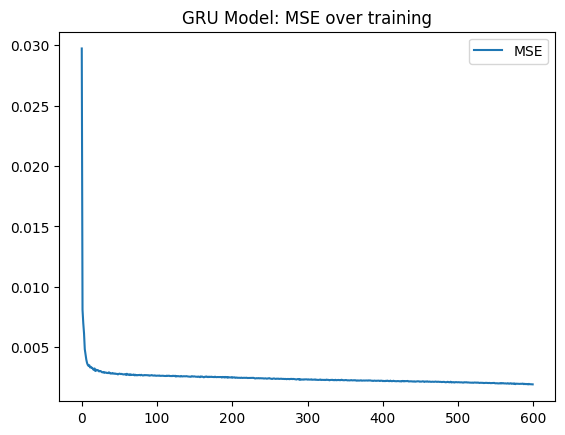

In [36]:
from matplotlib import pyplot as plt 

# plot history

# print(history)

X_axis = np.arange(epochs)

plt.title("GRU Model: MSE over training")

plt.plot(X_axis, history["mse"], label = "MSE")
# plt.plot(X_axis, history["mape"], label = "MAPE")

plt.legend()
plt.show()


In [ ]:
# TODO: Finished implementing the SAES model.

def get_sae(inputs: int, hidden: int, output: int) -> nn.Sequential:
    model = nn.Sequential(
        nn.Linear(inputs, hidden),
        nn.Sigmoid(),
        nn.Dropout(0.2),
        nn.Linear(hidden, output),
        nn.Sigmoid()
    )
    return model

class SAES(nn.Module):
    def __init__(self, layers: list[int], *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        assert len(layers) == 5, f"Error: invalid length of SAES layer: {len(layers)}"
        sae1 = get_sae(layers[0], layers[1], layers[-1])
        sae2 = get_sae(layers[1], layers[2], layers[-1])
        sae3 = get_sae(layers[2], layers[3], layers[-1])
        self.saes = nn.Sequential(
            
        )
        
        self.model = nn.Sequential(
            sae1, sae2, sae3
        )
    
        
        
        